In [65]:
import pandas as pd
import numpy as np
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
%matplotlib inline
spark = SparkSession.builder.master('local').getOrCreate()

In [66]:
'''
Prepare data for linear regression. This includes:

1. Linear assumptions (dependant vs. independant)
2. Removing noise (outliers)
3. Removing collinearity 
4. Transforming into Gaussian Distribution
5. Normalize inputs
'''

# Clean up data by removing incomplete entries. Any row with null values will not be considered for linear regression.
# Initial dataset has 1161 data entries. After dropping incomplete data, we have 1074 data entries with no null values.
df1 = pd.read_csv('aaup.csv')
print("{:.0f} data entries (raw data)".format(len(df1.index)))
df2 = df1.dropna()
print("{:.0f} data entries (removed incomplete data)".format(len(df2.index)))

1161 data entries (raw data)
1074 data entries (removed incomplete data)


In [67]:
# Visualize outliers for Full Professor Comp, Associate Professor Comp, Assistant Professor Comp, All Rank Comp

# Full Professor Comp
fig = px.histogram(df2, x='Full Professor Comp', nbins=100,
                   text_auto=True, title='Count of Full Professor Compensations')
fig.show()

# Associate Professor Comp
fig = px.histogram(df2, x='Associate Professor Comp', nbins=100,
                   text_auto=True, title='Count of Associate Professor Compensations')
fig.show()

# Assistant Professor Comp
fig = px.histogram(df2, x='Assistant Professor Comp', nbins=100,
                   text_auto=True, title='Count of Assistant Professor Compensations')
fig.show()

# All Rank Comp
fig = px.histogram(df2, x='All Rank Comp', nbins=100,
                   text_auto=True, title='Count of All Rank Compensations')
fig.show()


In [68]:
import os

df = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=',',
).csv(os.path.expanduser('~/cp468-Project/aaup.csv'))
df.printSchema()
df.show()

root
 |-- Row: integer (nullable = true)
 |-- FICE: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Postal: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Full Professor Salary: double (nullable = true)
 |-- Associate Professor Salary: double (nullable = true)
 |-- Assistant Professor Salary: double (nullable = true)
 |-- All Rank Salary: integer (nullable = true)
 |-- Full Professor Comp: double (nullable = true)
 |-- Associate Professor Comp: double (nullable = true)
 |-- Assistant Professor Comp: double (nullable = true)
 |-- All Rank Comp: integer (nullable = true)
 |-- Number of Full Professors: integer (nullable = true)
 |-- Number of Associate Professors: integer (nullable = true)
 |-- Number of Assistant Professors: integer (nullable = true)
 |-- Number of Instructors: integer (nullable = true)
 |-- Number of All Rank Faculty: integer (nullable = true)

+---+-----+--------------------+------+----+---------------------+----------------------

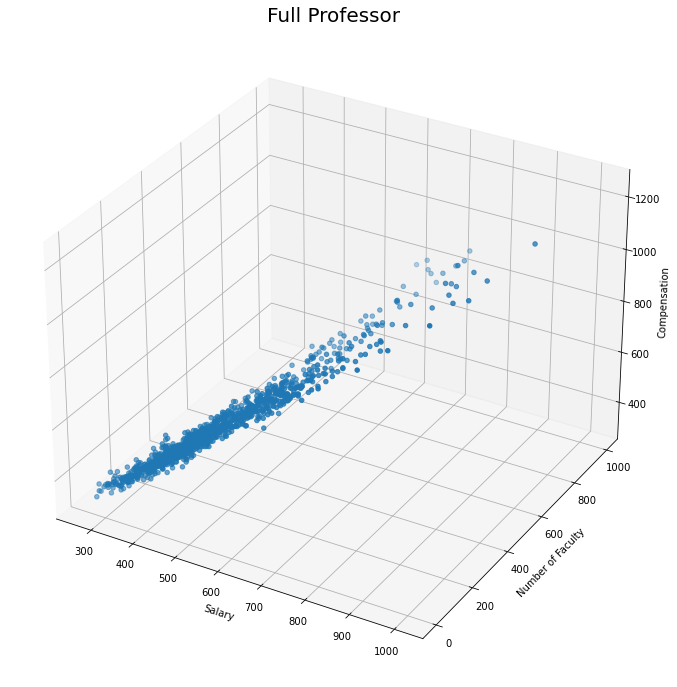

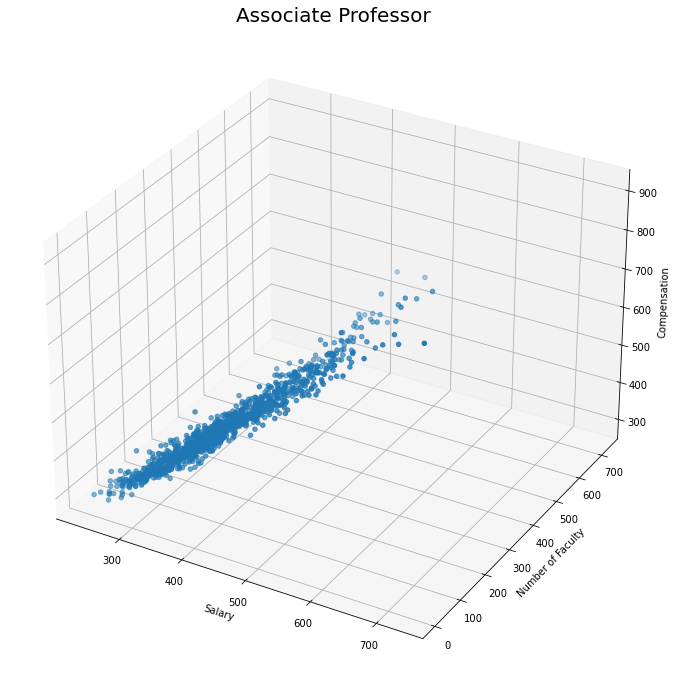

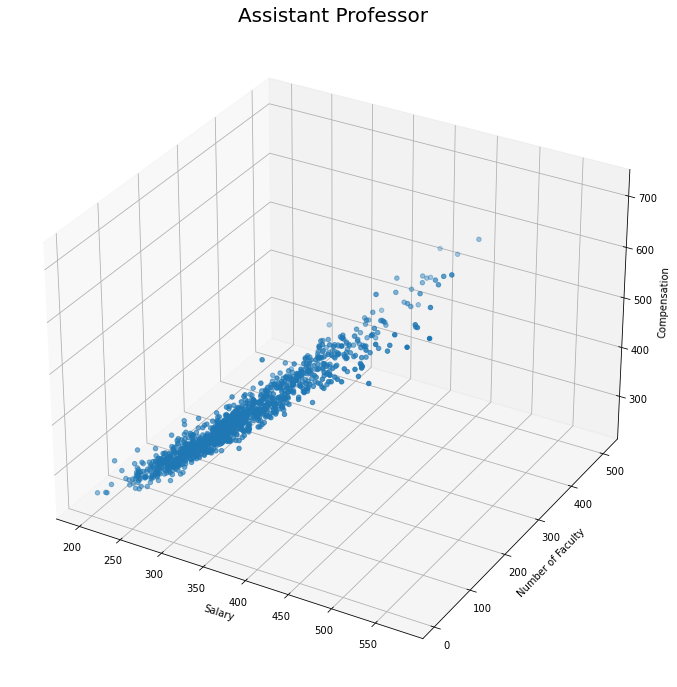

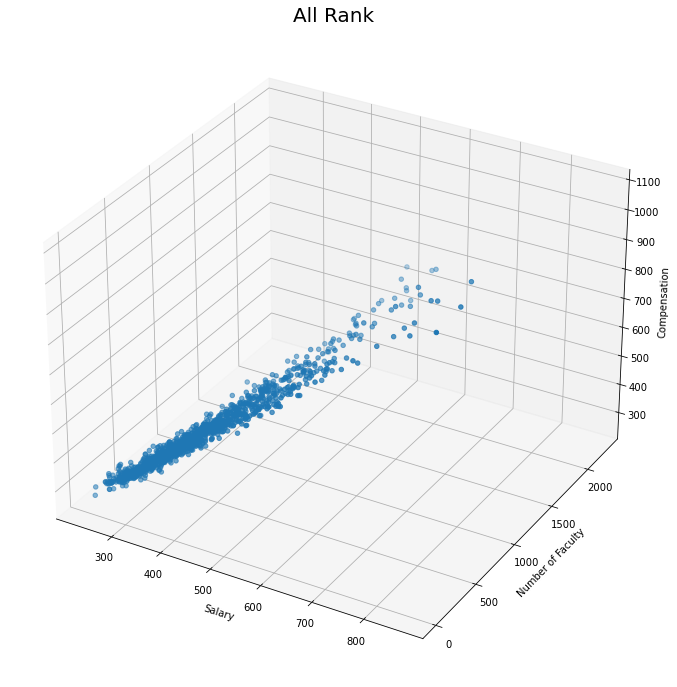

In [69]:
plt.rcParams["figure.figsize"] = (12,12)

fullArray = df.select(col("Full Professor Salary"), col("Number of Full Professors"),col("Full Professor Comp")).collect()
associateArray = df.select(col("Associate Professor Salary"), col("Number of Associate Professors"),col("Associate Professor Comp")).collect()
assistantArray = df.select(col("Assistant Professor Salary"), col("Number of Assistant Professors"),col("Assistant Professor Comp")).collect()
allArray = df.select(col("All Rank Salary"), col("Number of All Rank Faculty"),col("All Rank Comp")).collect()

# Full Professor
x = []
y = []
z = []
for i in range(len(fullArray)):
    x.append(fullArray[i][0])
    y.append(fullArray[i][1])
    z.append(fullArray[i][2])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)
ax.set_xlabel('Salary')
ax.set_ylabel('Number of Faculty')
ax.set_zlabel('Compensation')
plt.title("Full Professor", fontsize = 20)
plt.show()

# Associate Professor
x = []
y = []
z = []
for i in range(len(associateArray)):
    x.append(associateArray[i][0])
    y.append(associateArray[i][1])
    z.append(associateArray[i][2])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)
ax.set_xlabel('Salary')
ax.set_ylabel('Number of Faculty')
ax.set_zlabel('Compensation')
plt.title("Associate Professor", fontsize = 20)
plt.show()

# Assistant Professor
x = []
y = []
z = []
for i in range(len(assistantArray)):
    x.append(assistantArray[i][0])
    y.append(assistantArray[i][1])
    z.append(assistantArray[i][2])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)
ax.set_xlabel('Salary')
ax.set_ylabel('Number of Faculty')
ax.set_zlabel('Compensation')
plt.title("Assistant Professor", fontsize = 20)
plt.show()

# All Rank
x = []
y = []
z = []
for i in range(len(allArray)):
    x.append(allArray[i][0])
    y.append(allArray[i][1])
    z.append(allArray[i][2])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)
ax.set_xlabel('Salary')
ax.set_ylabel('Number of Faculty')
ax.set_zlabel('Compensation')
plt.title("All Rank", fontsize = 20)
plt.show()

In [70]:
# Computes Z-score of each respective column, and removes rows with Z-scores above 3. 1058 data entries now.
df3 = df2[(np.abs(stats.zscore(df2['Full Professor Comp'])) < 3)]
df3 = df3[(np.abs(stats.zscore(df3['Associate Professor Comp'])) < 3)]
df3 = df3[(np.abs(stats.zscore(df3['Assistant Professor Comp'])) < 3)]
df3 = df3[(np.abs(stats.zscore(df3['All Rank Comp'])) < 3)]
print("{:.0f} data entries (removed outliers)".format(len(df3.index)))

1058 data entries (removed outliers)


In [71]:
corr_data = df3.corr(method='pearson')
corr_data.to_csv("correlationCoefficients.csv", encoding='utf-8', index=True)

'''
We can see from the variable correlation coefficients that there is high correlation between the different salaries
of each rank. Although high correlation in linear regression models can cause problems with multicollinearity and make
regression coefficients unreliable, we do not need to remove any of the features because the highly correlated features
will be modelled in seperate linear regression equations.
'''

'\nWe can see from the variable correlation coefficients that there is high correlation between the different salaries\nof each rank. Although high correlation in linear regression models can cause problems with multicollinearity and make\nregression coefficients unreliable, we do not need to remove any of the features because the highly correlated features\nwill be modelled in seperate linear regression equations.\n'

In [86]:
x = df3[['Full Professor Salary', "Number of Full Professors"]]
y = df3['Full Professor Comp']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

model = LinearRegression()
model.fit(x_train, y_train)
print(model.coef_)
print(model.intercept_)

pd.DataFrame(model.coef_, x.columns, columns = ['Coeff'])

predictions = model.predict(x_test)

print(metrics.mean_absolute_error(y_test, predictions))

print(metrics.mean_squared_error(y_test, predictions))

print(np.sqrt(metrics.mean_squared_error(y_test, predictions)))

[ 1.29825179 -0.02867791]
-23.828804243035506
16.57703863349319
477.2632379161607
21.846355254736675


In [87]:
x = df3[['Associate Professor Salary', "Number of Associate Professors"]]
y = df3['Associate Professor Comp']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

model = LinearRegression()
model.fit(x_train, y_train)
print(model.coef_)
print(model.intercept_)

pd.DataFrame(model.coef_, x.columns, columns = ['Coeff'])

predictions = model.predict(x_test)

print(metrics.mean_absolute_error(y_test, predictions))

print(metrics.mean_squared_error(y_test, predictions))

print(np.sqrt(metrics.mean_squared_error(y_test, predictions)))

[ 1.35568907 -0.03292018]
-38.434958446472706
14.766902946740414
347.3189022099251
18.63649382823725


In [88]:
x = df3[['Assistant Professor Salary', "Number of Assistant Professors"]]
y = df3['Assistant Professor Comp']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

model = LinearRegression()
model.fit(x_train, y_train)
print(model.coef_)
print(model.intercept_)

pd.DataFrame(model.coef_, x.columns, columns = ['Coeff'])

predictions = model.predict(x_test)

print(metrics.mean_absolute_error(y_test, predictions))

print(metrics.mean_squared_error(y_test, predictions))

print(np.sqrt(metrics.mean_squared_error(y_test, predictions)))

[ 1.34783096 -0.01453419]
-30.95948053714858
12.609667987741437
263.7953112963445
16.24177672843536


In [89]:
x = df3[['All Rank Salary', "Number of All Rank Faculty"]]
y = df3['All Rank Comp']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

model = LinearRegression()
model.fit(x_train, y_train)
print(model.coef_)
print(model.intercept_)

pd.DataFrame(model.coef_, x.columns, columns = ['Coeff'])

predictions = model.predict(x_test)

print(metrics.mean_absolute_error(y_test, predictions))

print(metrics.mean_squared_error(y_test, predictions))

print(np.sqrt(metrics.mean_squared_error(y_test, predictions)))

[ 1.31780312 -0.00999107]
-24.863650668791138
14.232404096131768
325.64548647113395
18.045650070616297
